In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import chain

from monte_carlo_return import (
    generate_bet_return,
    compute_objective_via_simulation,
    minimize_simulation,
    INDEX_TO_SCENARIO
)
from analytical_return import (
    expectation,
    second_moment,
    variance,
    compute_objective_via_analytical,
    minimize_analytical,
    softmax,
)
from data import (
    load_metadata_artefacts,
    load_odds,
    build_empty_dataframe,
    apply_final_treatment,
)
from GameProbs import GameProbs
from utils import get_favorable_scenarios
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
metadata, gameid_to_outcome = load_metadata_artefacts("data/metadata.parquet")
odds = load_odds("data/odds.parquet")
print(metadata.shape)
print(odds.shape)

(16898, 8)
(2003933, 7)


## Create bets dataframe for a game
Now, we create a bets dataframe for the game, considering multiple Sportsbooks, except the one used for the real probabilities.

In [4]:
GAME_ID = "5254998" # Chapecoense x Flamengo
my_game = GameProbs(GAME_ID) 
df = my_game.build_dataframe()
df

,0,1,2,3,4,5,6
0,0.0289,0.0216,0.0100,0.0033,0.0008,0.0002,0.0000
1,0.0632,0.0598,0.0239,0.0076,0.0019,0.0004,0.0001
2,0.0880,0.0717,0.0354,0.0097,0.0024,0.0005,0.0001
3,0.0873,0.0688,0.0292,0.0108,0.0022,0.0004,0.0001
4,0.0692,0.0529,0.0220,0.0066,0.0022,0.0003,0.0001
5,0.0466,0.0347,0.0142,0.0042,0.0010,0.0004,0.0000
6,0.0558,0.0398,0.0158,0.0045,0.0011,0.0002,0.0001


In [5]:
odds.head()

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob
0,2738735,Bet365,h2h,,home,1.72,0.581395
1,2738735,Bet365,h2h,,draw,3.50,0.285714
2,2738735,Bet365,h2h,,away,4.75,0.210526
3,2738735,Bet365,over/under,0.5,over,1.08,0.925926
4,2738735,Bet365,over/under,0.5,under,8.00,0.125000


In [6]:
# Example of match that has 46 options of exact result bet 
sportsbook_list = ['1xBet', 'Megapari Sport', 'NetBet', 'Betobet', '18Bet', 'Mr Green Sport', 'Parimatch', 'Bet365']
odds_sample = odds[(odds.Sportsbook.isin(sportsbook_list))&(odds.GameId==GAME_ID)]
print(odds_sample.shape)

# Join metadata info to the odds dataframe
odds_sample = pd.merge(odds_sample, metadata[['GameId', 'Home', 'Away']], on=['GameId'], how='left')
print(odds_sample.shape)

(680, 7)
(680, 9)


In [7]:
odds_sample = apply_final_treatment(df_odds=odds_sample, df_real_prob=df)
odds_sample

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag
0,5254998,1xBet,exact,0 : 0,o,11.00,0.090909,Chapecoense,Flamengo,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0289,False
1,5254998,1xBet,exact,0 : 1,o,6.00,0.166667,Chapecoense,Flamengo,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0632,False
2,5254998,1xBet,exact,0 : 2,o,6.00,0.166667,Chapecoense,Flamengo,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0880,False
3,5254998,1xBet,exact,0 : 3,o,9.00,0.111111,Chapecoense,Flamengo,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0873,False
4,5254998,1xBet,exact,0 : 4,o,15.00,0.066667,Chapecoense,Flamengo,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0692,True
...,...,...,...,...,...,...,...,...,...,...,...,...
488,5254998,Bet365,spread,+1/-1,home,3.00,0.333333,Chapecoense,Flamengo,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...",0.2232,False
489,5254998,Bet365,spread,+1/-1,draw,3.60,0.277778,Chapecoense,Flamengo,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.1719,False
490,5254998,Bet365,spread,+1/-1,away,2.00,0.500000,Chapecoense,Flamengo,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",0.6049,True
491,5254998,Bet365,both_score,,yes,2.00,0.500000,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True


## Bet Allocation (F2)

In [8]:
odds_sample = odds_sample[odds_sample.Market.isin(['exact', 'both_score'])]
#odds_sample = odds_sample[odds_sample.Market.isin(['exact'])]

In [9]:
odds_sample_favorable = odds_sample[odds_sample.bet_flag].copy(deep=True).reset_index(drop=True)
print(odds_sample_favorable.shape)

(54, 12)


In [10]:
n = len(odds_sample_favorable)
allocation_array = np.round(np.array(((1/n), ) * n), 4)
allocation_array

array([0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [11]:
#df_log = build_empty_dataframe(7, 7, 0)

In [12]:
#odds_sample_favorable['allocation_array'] = allocation_array

In [43]:
allocation_array = solution
financial_return_array = generate_bet_return(df_prob=df,
                                             df_bet=odds_sample_favorable,
                                             num_simulations=30000,
                                             allocation_array=allocation_array)
financial_return_array                                             

Running generate_bet_return
sampled_result: 0 : 4 ---------- financial_return: 1.7231677393680818
sampled_result: 1 : 1 ---------- financial_return: 1.7180120643493997
sampled_result: 0 : 3 ---------- financial_return: 0.0
sampled_result: 2 : 5 ---------- financial_return: 1.7283348400507386
sampled_result: 1 : 2 ---------- financial_return: 1.7180120643493997
sampled_result: 0 : 0 ---------- financial_return: 0.0
sampled_result: 2 : 1 ---------- financial_return: 1.7180120643493997
sampled_result: 0 : 0 ---------- financial_return: 0.0
sampled_result: 1 : 0 ---------- financial_return: 0.0
sampled_result: 0 : 2 ---------- financial_return: 0.0
sampled_result: 1 : 5 ---------- financial_return: 1.7319090784914435
sampled_result: 2 : 4 ---------- financial_return: 1.7180120643493997
sampled_result: 0 : 1 ---------- financial_return: 0.0
sampled_result: 0 : 4 ---------- financial_return: 1.7231677393680818
sampled_result: 1 : 2 ---------- financial_return: 1.7180120643493997
sampled_resu

array([1.72316774, 1.71801206, 0.        , ..., 0.        , 1.71801206,
       0.        ])

In [44]:
print(np.mean(financial_return_array))
print(np.std(financial_return_array))

1.198463568761181
0.792960103082686


In [46]:
#4.3267728000000005 / 5.370238491052344
#3.3057165240609123 / 2.4691537702461703
#3.666701490280025 / 3.34370661472899
#3.0827736576503217 / 2.2487296065006084
#2.4384799999999998/4.789840171780265
#1.5011996815226962/2.148751477147124
1.198463568761181/0.792960103082686

1.5113794049688918

In [15]:
odds_sample_favorable.iloc[[3,7], :]

,GameId,Sportsbook,Market,Scenario,Bet,Odd,public_prob,Home,Away,BetMap,real_prob,bet_flag,sample_flag
3,5254998,1xBet,exact,1 : 5,o,51.0,0.019608,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.0347,True,False
7,5254998,1xBet,both_score,,yes,2.2,0.454545,Chapecoense,Flamengo,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...",0.5251,True,True


In [15]:
from monte_carlo_return import get_favorable_scenarios
x = get_favorable_scenarios(odds_sample_favorable.BetMap[3])
y = get_favorable_scenarios(odds_sample_favorable.BetMap[7])

In [25]:
event_i = odds_sample_favorable.BetMap[3]
event_j = odds_sample_favorable.BetMap[7]
print(np.transpose(np.array(event_i).reshape(7,7)) * np.transpose(np.array(event_j).reshape(7,7)) * df.to_numpy())

[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.0347 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]]


In [24]:
df.to_numpy()

array([[0.0289, 0.0216, 0.01  , 0.0033, 0.0008, 0.0002, 0.    ],
       [0.0632, 0.0598, 0.0239, 0.0076, 0.0019, 0.0004, 0.0001],
       [0.088 , 0.0717, 0.0354, 0.0097, 0.0024, 0.0005, 0.0001],
       [0.0873, 0.0688, 0.0292, 0.0108, 0.0022, 0.0004, 0.0001],
       [0.0692, 0.0529, 0.022 , 0.0066, 0.0022, 0.0003, 0.0001],
       [0.0466, 0.0347, 0.0142, 0.0042, 0.001 , 0.0004, 0.    ],
       [0.0558, 0.0398, 0.0158, 0.0045, 0.0011, 0.0002, 0.0001]])

In [48]:
odds_favorable = np.array(odds_sample_favorable['Odd'])
real_prob_favorable = np.array(odds_sample_favorable['real_prob'])
#scenario_favorable = np.array(odds_sample_favorable['Bet'])
event_favorable = list(odds_sample_favorable['BetMap'].values)

my_expectation = expectation(allocation_array, odds_favorable, real_prob_favorable)
print(f"my_expectation: {my_expectation}")

my_second_moment = second_moment(allocation_array, odds_favorable, real_prob_favorable, event_favorable, df)
print(f"my_second_moment: {my_second_moment}")

my_sigma = np.sqrt(variance(my_second_moment, my_expectation))

print(f"my_sigma: {my_sigma}")

my_expectation: 1.2004068846321785
my_second_moment: 2.0683326769180725
my_sigma: 0.7920580712585032


## Financial Return (F3)

In [54]:
from utils import INDEX_TO_SCENARIO_BET_MAP
INDEX_TO_SCENARIO_BET_MAP

{0: '0 : 0',
 1: '0 : 1',
 2: '0 : 2',
 3: '0 : 3',
 4: '0 : 4',
 5: '0 : 5',
 6: '0 : 6',
 7: '1 : 0',
 8: '1 : 1',
 9: '1 : 2',
 10: '1 : 3',
 11: '1 : 4',
 12: '1 : 5',
 13: '1 : 6',
 14: '2 : 0',
 15: '2 : 1',
 16: '2 : 2',
 17: '2 : 3',
 18: '2 : 4',
 19: '2 : 5',
 20: '2 : 6',
 21: '3 : 0',
 22: '3 : 1',
 23: '3 : 2',
 24: '3 : 3',
 25: '3 : 4',
 26: '3 : 5',
 27: '3 : 6',
 28: '4 : 0',
 29: '4 : 1',
 30: '4 : 2',
 31: '4 : 3',
 32: '4 : 4',
 33: '4 : 5',
 34: '4 : 6',
 35: '5 : 0',
 36: '5 : 1',
 37: '5 : 2',
 38: '5 : 3',
 39: '5 : 4',
 40: '5 : 5',
 41: '5 : 6',
 42: '6 : 0',
 43: '6 : 1',
 44: '6 : 2',
 45: '6 : 3',
 46: '6 : 4',
 47: '6 : 5',
 48: '6 : 6'}

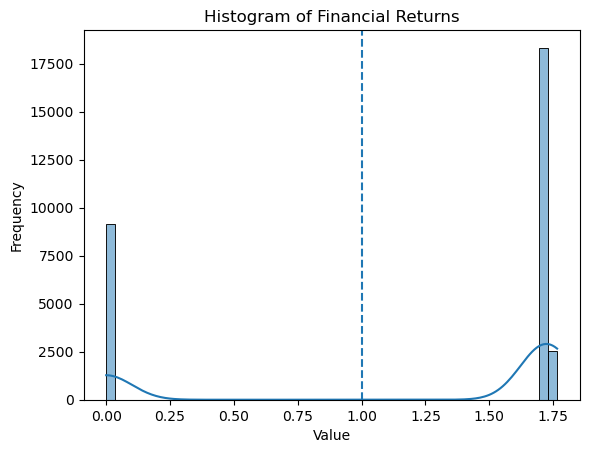

In [53]:
cost = 1
result = financial_return_array - cost

# Plot a histogram using Seaborn
sns.histplot(financial_return_array, bins=50, kde=True)

# Add a vertical line
plt.axvline(x=cost, linestyle='--')
#plt.axvline(x=0, linestyle='--')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Financial Returns')

# Show the plot
plt.show()

In [27]:
# compute_objective_via_simulation(x=allocation_array,
#                                  df_prob=df,
#                                  df_bet=odds_sample_favorable,
#                                  num_simulations=50000)

In [25]:
allocation_array

array([0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [36]:
x0 = np.zeros(54)
x0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [33]:
from analytical_return import softmax

In [37]:
softmax(x0)

array([0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852, 0.01851852,
       0.01851852, 0.01851852, 0.01851852, 0.01851852])

In [38]:
compute_objective_via_analytical(x=x0,
                                 public_odd=odds_favorable,
                                 real_probabilities=real_prob_favorable,
                                 event=event_favorable,
                                 df_prob=df)

my_expectation: 2.135175111111111
my_sigma: 4.006976028224116


-0.5328644584024168

In [ ]:
# solution = minimize_simulation(df_prob=df,
#                                df_bet=odds_sample_favorable,
#                                num_simulations=10000)

In [21]:
allocation_array

array([0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185,
       0.0185, 0.0185, 0.0185, 0.0185, 0.0185, 0.0185])

In [40]:
solution = minimize_analytical(public_odd=odds_favorable,
                               real_probabilities=real_prob_favorable,
                               event=event_favorable,
                               df_prob=df)

x0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
my_expectation: 2.135175111111111
my_sigma: 4.006976028224116
my_expectation: 2.135175110808347
my_sigma: 4.0069760270452
my_expectation: 2.135175111049139
my_sigma: 4.006976027397884
my_expectation: 2.1351751120770985
my_sigma: 4.006976030113394
my_expectation: 2.1351751110102577
my_sigma: 4.006976027559091
my_expectation: 2.135175111905735
my_sigma: 4.006976030618367
my_expectation: 2.135175110878493
my_sigma: 4.006976027380858
my_expectation: 2.1351751113982673
my_sigma: 4.006976030829379
my_expectation: 2.135175110840694
my_sigma: 4.006976027147022
my_expectation: 2.135175110808347
my_sigma: 4.0069760270452
my_expectation: 2.135175110894829
my_sigma: 4.006976027316085
my_expectation: 2.135175111307205
my_sigma: 4.006976028630725
my_expectation: 2.1351751108284636
my_sigma: 4.006976027038018
my_expectation: 2.135175

In [41]:
print(sum(solution))
solution = softmax(solution)
print(sum(solution))

-0.00029786136754417214
0.9999999999999998


In [42]:
odds_sample_favorable[['Market', 'Sportsbook', 'Scenario', 'Odd', 'public_prob', 'real_prob']].assign(solution=np.round(solution, 3)).sort_values(['solution'], ascending=False)
#odds_sample[['Market', 'Scenario', 'Odd', 'public_prob', 'real_prob', 'bet_flag']].assign(solution=solution)

,Market,Sportsbook,Scenario,Odd,public_prob,real_prob,solution
7,both_score,1xBet,,2.20,0.454545,0.5251,0.217
44,both_score,Megapari Sport,,2.20,0.454545,0.5251,0.217
21,both_score,NetBet,,2.10,0.476190,0.5251,0.098
36,both_score,18Bet,,2.03,0.492611,0.5251,0.061
16,both_score,Betobet,,2.03,0.492611,0.5251,0.061
27,both_score,Parimatch,,2.00,0.500000,0.5251,0.051
52,both_score,Mr Green Sport,,2.00,0.500000,0.5251,0.051
53,both_score,Bet365,,2.00,0.500000,0.5251,0.051
8,exact,Betobet,0 : 4,15.00,0.066667,0.0692,0.029
28,exact,18Bet,0 : 4,15.00,0.066667,0.0692,0.029
